Faizaan Ali | Homework 2

# Import Data and Preprocess

In [1]:
import pandas as pd
import numpy as np

cols = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week",
    "native_country", "income"
]

# URL for the UCI Adult dataset (same as HW1)
# Source: https://archive.ics.uci.edu/ml/datasets/adult
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
adult = pd.read_csv(url, header=None, names=cols, na_values=" ?", skipinitialspace=True)

# remove missing values
adult.dropna(inplace=True)

# target var
y = adult["income"].map({"<=50K": 0, ">50K": 1})

# features
X = adult.drop(columns=["income"])

# encode categoricals
categorical_cols = X.select_dtypes(include="object").columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
print("Feature matrix shape:", X_encoded.shape)
print("Target distribution:\n", y.value_counts(normalize=True))

Feature matrix shape: (32561, 100)
Target distribution:
 income
0    0.75919
1    0.24081
Name: proportion, dtype: float64


This preprocessing pipeline is appropriate for training decision trees and ensemble tree-based models. One-hot encoding enables categorical feature handling while preserving interpretability, and no feature scaling is required. The final feature space is well-suited for tree models that we now will implement.

# Task 1

## Visualize Decision Tree Structures (Varying Max_Depth)

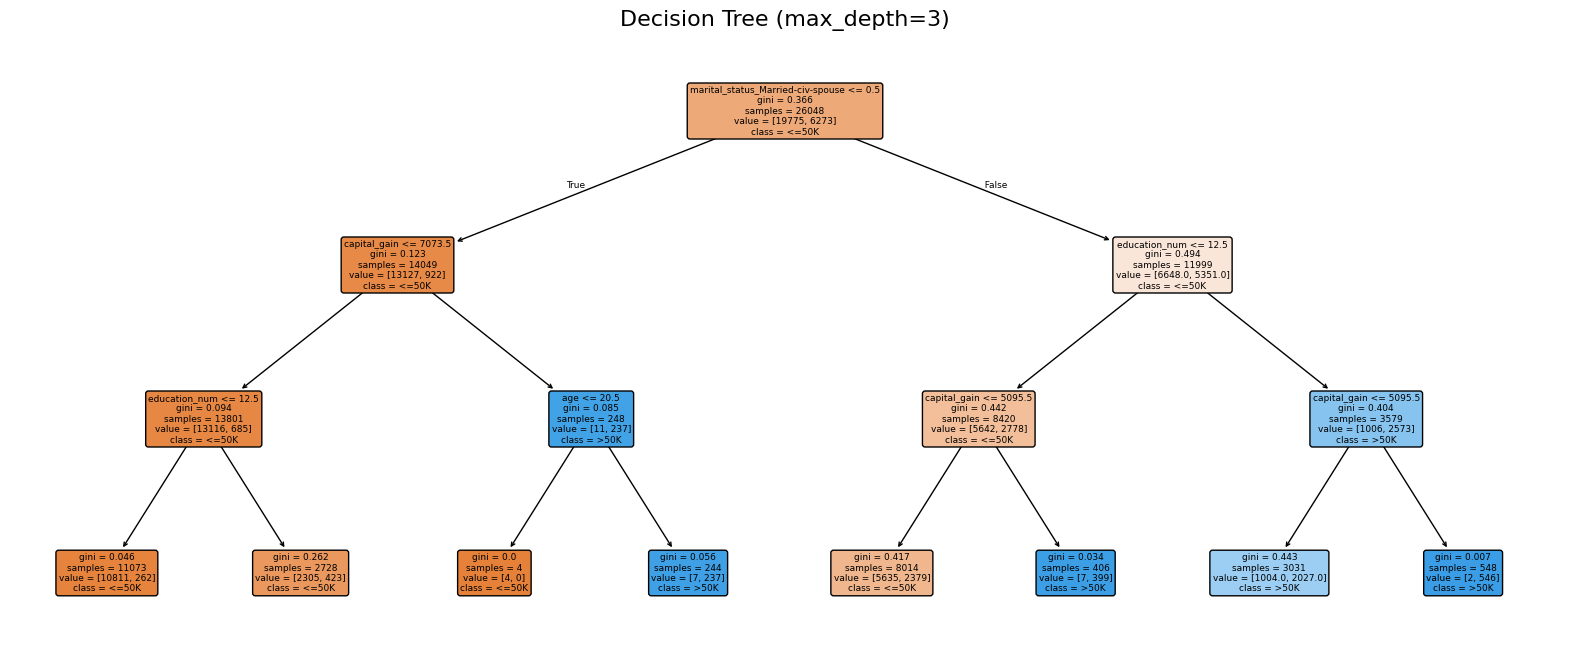

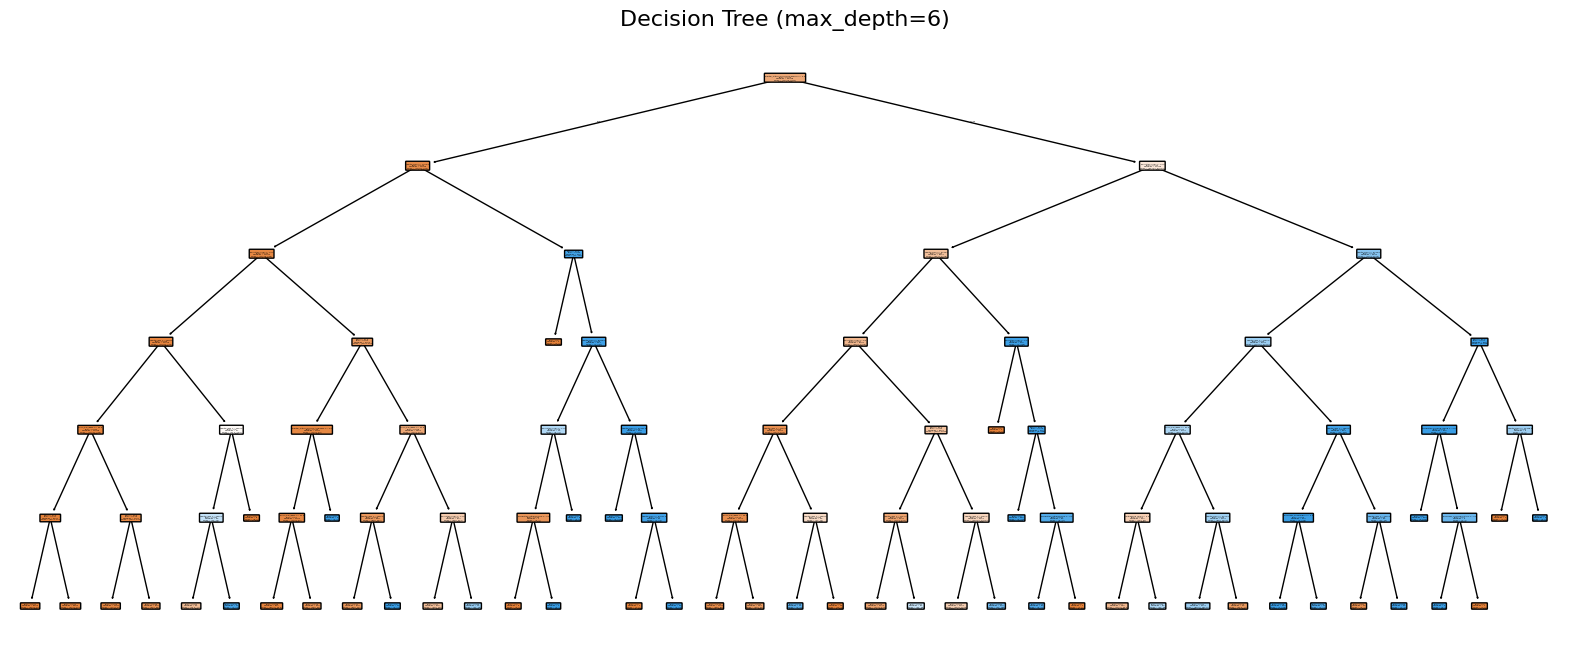

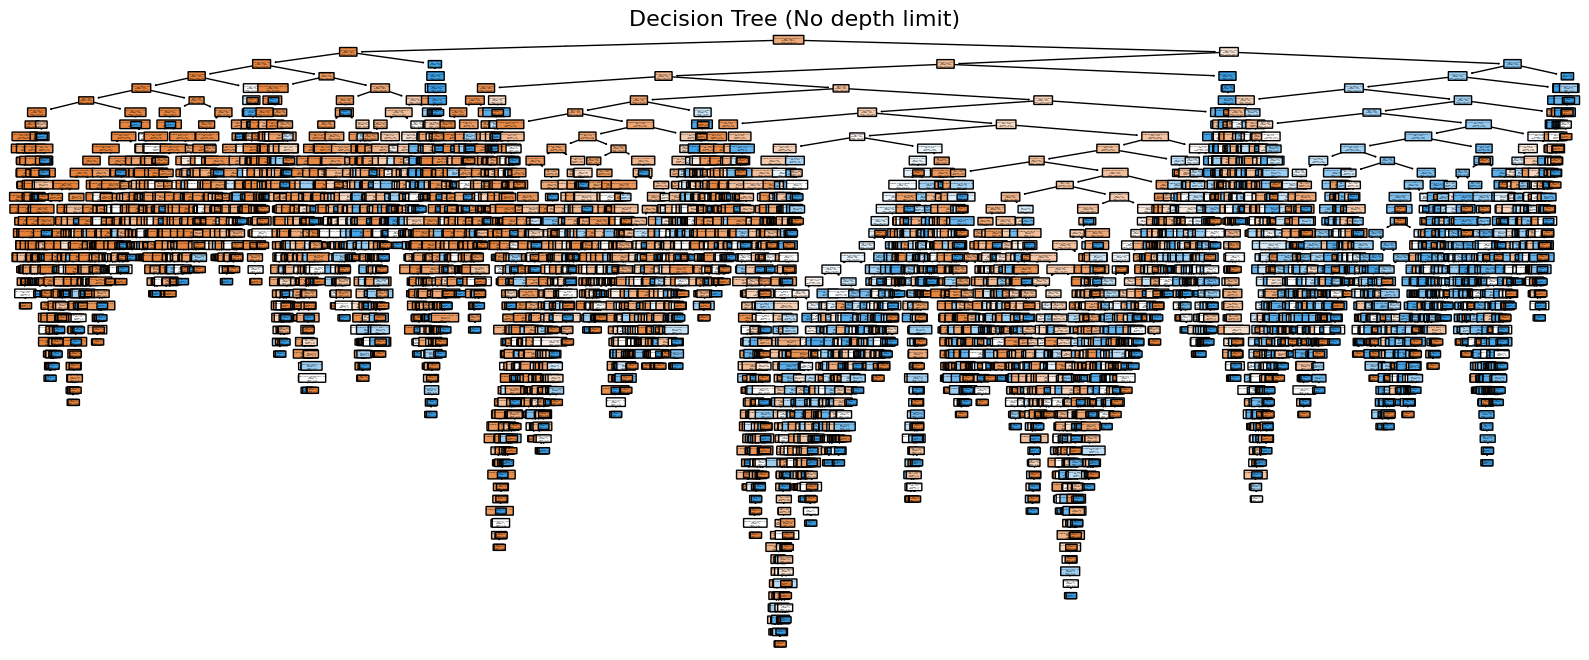

In [2]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# experiment parameters
tree_configs = [
    {"max_depth": 3, "title": "Decision Tree (max_depth=3)"},
    {"max_depth": 6, "title": "Decision Tree (max_depth=6)"},
    {"max_depth": None, "title": "Decision Tree (No depth limit)"}
]

# training loop
for cfg in tree_configs:
    clf = DecisionTreeClassifier(
        max_depth=cfg["max_depth"],
        random_state=42
    )
    clf.fit(X_train, y_train)

    plt.figure(figsize=(20, 8))
    plot_tree(
        clf,
        feature_names=X_encoded.columns,
        class_names=["<=50K", ">50K"],
        filled=True,
        rounded=True,
    )
    plt.title(cfg["title"], fontsize=16)
    plt.show()

For this first task, I ran an experiment with varying max_depth settings when initializing the DecisionTreeClassifier (DTC). I tested max depths of 3, 6, and unbounded, training 3 different DTCs. Then, I plotted the trees using a convenient visualization function from Scikit. Based on the plots above, we can immediately notice how capping the tree depth impacts the complexity of the model.

Shallow tree (max_depth = 3):
- The tree is very small and interpretable, using only the most informative features (e.g., education, marital status). However, it likely underfits the data due to its limited complexity.

Medium-depth tree (max_depth = 6)
- The tree captures many more decision boundaries by incorporating additional feature splits, most likely improving its predictive power while remaining reasonably interpretable.

Unrestricted tree (no depth limit)
- The tree grows very deep with many branches, fitting the training data very closely. This increases model complexity drastically and raises the risk of overfitting. Also, this makes the model harder to interpret and less likely to generalize to new data.

## Sensitivity Analysis

https://en.wikipedia.org/wiki/Sensitivity_analysis#One-at-a-time_(OAT)

Sensitivity analysis is a statistical method used to determine how different values of an independent variable affect a specific dependent variable under set assumptions. In terms of model feature analysis, we generate synthetic average points, with only one attribute varied on some range. Plotting the confidence probabilities for each iteration reveals thresholds in that feature for classification boundaries.  

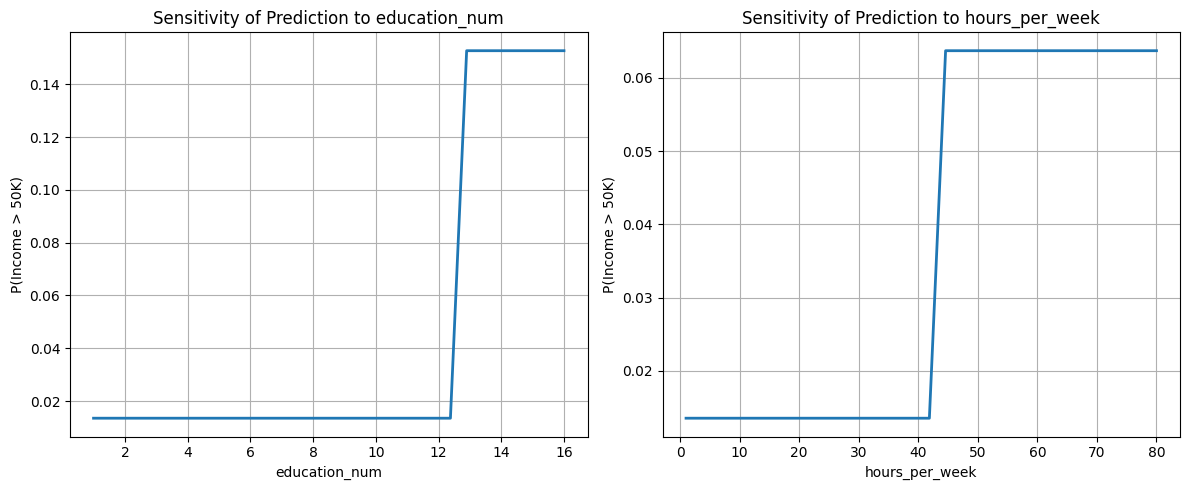

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)

# vars to analyze
features_to_analyze = ["education_num", "hours_per_week"]

# baseline synthetic point
baseline = X_train.mean().to_frame().T

# range for new values
ranges = {
    "education_num": np.linspace(1, 16, 30),
    "hours_per_week": np.linspace(1, 80, 30)
}

# run sensitivity analysis
# following One At A Time method: https://en.wikipedia.org/wiki/Sensitivity_analysis#One-at-a-time_(OAT)
plt.figure(figsize=(12, 5))
for i, feature in enumerate(features_to_analyze):
    probs = []

    for val in ranges[feature]:
        x_mod = baseline.copy()
        x_mod[feature] = val # augment synthetic point with new value from range
        prob = dt.predict_proba(x_mod)[0, 1]  # P(income > 50K)
        probs.append(prob)

    plt.subplot(1, 2, i + 1)
    plt.plot(ranges[feature], probs, linewidth=2)
    plt.xlabel(feature)
    plt.ylabel("P(Income > 50K)")
    plt.title(f"Sensitivity of Prediction to {feature}")
    plt.grid(True)

plt.tight_layout()
plt.show()

Education level (education_num) shows a sharp jump in predicted probability around a specific threshold (≈12–13 years of education). This shows the decision tree’s split-based structure: once the feature crosses a learned cutoff, the model moves the sample to a different leaf with a much higher probability of earning >50K.

Hours worked per week (hours_per_week) has a similar jump near ~40–45 hours. Below this threshold, predictions remain nearly constant; above it, the probability increases abruptly, indicating a strong decision boundary learned by the tree around this mark.

Both plots show that decision trees produce piecewise-constant decision boundaries, making predictions highly sensitive to small changes near split thresholds but insensitive elsewhere. This behavior explains how the DTC can have potential instability around boundary values.

# Task 2

In [4]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, f1_score

# model definitions
models = {
    "Random Forest (Bagging)": RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ),
    "AdaBoost (Boosting)": AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=200,
        learning_rate=0.5,
        random_state=42
    )
}

# run strat k fold CV
folds_list = [5, 10, 15]

results = []

for k in folds_list:
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    for model_name, model in models.items():
        accs, precs, f1s = [], [], []

        for train_idx, test_idx in skf.split(X_encoded, y):
            X_train, X_test = X_encoded.iloc[train_idx], X_encoded.iloc[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            accs.append(accuracy_score(y_test, y_pred))
            precs.append(precision_score(y_test, y_pred))
            f1s.append(f1_score(y_test, y_pred))

        results.append({
            "Model": model_name,
            "Folds": k,
            "Accuracy": np.mean(accs),
            "Precision": np.mean(precs),
            "F1-score": np.mean(f1s)
        })

# Results table
results_df = pd.DataFrame(results)
print(results_df)

                     Model  Folds  Accuracy  Precision  F1-score
0  Random Forest (Bagging)      5  0.855686   0.735547  0.676174
1      AdaBoost (Boosting)      5  0.855348   0.779304  0.649890
2  Random Forest (Bagging)     10  0.855410   0.736178  0.674840
3      AdaBoost (Boosting)     10  0.854918   0.776190  0.649502
4  Random Forest (Bagging)     15  0.854550   0.733358  0.673217
5      AdaBoost (Boosting)     15  0.855041   0.776207  0.649993


## Discussion

Across all fold settings (5, 10, and 15), Random Forest (bagging) and AdaBoost (boosting) achieve very similar accuracy (~ 0.855), indicating that both models perform comparably in terms of overall correctness on the Adult dataset. This is expected, since accuracy is dominated by the majority class (<=50K), which both ensemble methods handle well.

However, the performance ranking changes when looking specifically at precision and F1-score. AdaBoost consistently achieves higher precision, meaning it is more conservative and makes fewer false positive predictions for the >50K class. In contrast, Random Forest achieves a higher F1-score, indicating a better balance between precision and recall. This suggests that Random Forest captures more true positives overall, even if it allows slightly more false positives.

The difference in results is most likely because boosting explicitly focuses on hard-to-classify samples, improving precision by emphasizing misclassified points, while bagging reduces variance by averaging many independent trees, leading to more balanced predictions. So, the preferred algorithm depends on the metric of interest: AdaBoost is preferable when minimizing false positives is critical, while Random Forest is better for when one wants a more balanced class performance.

# Task 3

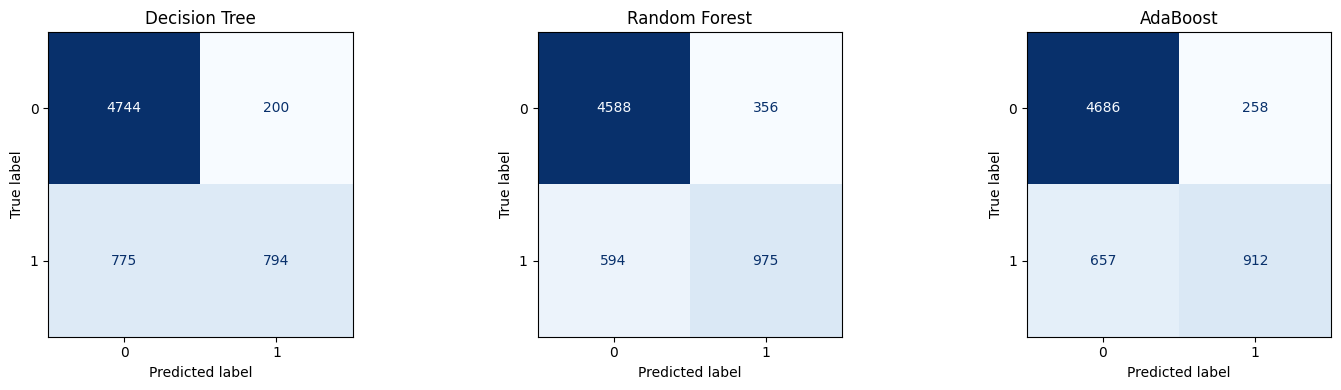

Paired t-test results (F1-score):

Decision Tree vs Random Forest: t = -10.185, p = 0.0005
Decision Tree vs AdaBoost: t = -8.442, p = 0.0011
Random Forest vs AdaBoost: t = 2.877, p = 0.0452


In [5]:
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from scipy.stats import ttest_rel

# create folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, test_idx = next(skf.split(X_encoded, y))  # take first fold

X_np = X_encoded.values
y_np = y.values

X_train_fold, X_test_fold = X_np[train_idx], X_np[test_idx]
y_train_fold, y_test_fold = y_np[train_idx], y_np[test_idx]


models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42)
}

plt.figure(figsize=(15, 4))

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_test_fold) # test all models on same fold

    cm = confusion_matrix(y_test_fold, y_pred)
    disp = ConfusionMatrixDisplay(cm)

    plt.subplot(1, 3, i + 1)
    disp.plot(cmap="Blues", ax=plt.gca(), colorbar=False)
    plt.title(name)

plt.tight_layout()
plt.show()


# t-tests
f1_scores = {}

for name, model in models.items():
    scores = cross_val_score(
        model,
        X_np,
        y,
        cv=skf,
        scoring="f1"
    )
    f1_scores[name] = scores

# Pairwise t-tests
print("Paired t-test results (F1-score):\n")

pairs = [
    ("Decision Tree", "Random Forest"),
    ("Decision Tree", "AdaBoost"),
    ("Random Forest", "AdaBoost")
]

for m1, m2 in pairs:
    t_stat, p_val = ttest_rel(f1_scores[m1], f1_scores[m2])
    print(f"{m1} vs {m2}: t = {t_stat:.3f}, p = {p_val:.4f}")

## Discussion

https://www.geeksforgeeks.org/machine-learning/bias-vs-variance-in-machine-learning/

https://www.jmp.com/en/statistics-knowledge-portal/t-test

In a paired t-test, the t-value measures how large the average performance difference between two models is relative to its variability, while the p-value indicates the probability of observing such a difference by chance. Basically, a small p-value means the performance difference is statistically significant rather than random.

The single decision tree has low bias because it can closely fit the training data, but this flexibility leads to high variance. As a result, the model is sensitive to fluctuations in the training set and tends to overfit. This also limits its ability to generalize. This behavior is shown in its lower F1-score and higher number of misclassifications compared to the ensemble methods. In the pair tests, it had large negative t-values with low p-values meaning that the ensemble methods' gains are statistically significant.

RandomForest uses bagging to train many simple trees on different bootstrapped samples and then averages their predictions. This significantly reduces variance while maintaining relatively low bias, resulting in more stable and reliable predictions. In the results, Random Forest achieves the strongest overall performance, with higher true positive counts and statistically significant improvements over both the single decision tree and AdaBoost. Specifically, versus AdaBoost, it had a slightly positive t value with p of < 0.05, meaning there is a modest but consistent advantage in F1 scores.

AdaBoost focuses on reducing bias by iteratively reweighting misclassified samples so that harder cases receive more attention in the next model. While this improves learning of complex patterns, it also increases sensitivity to noise, which can introduce additional variance. Consequently, AdaBoost outperforms a single decision tree but falls slightly behind Random Forest, highlighting the trade-off between aggressive bias reduction and vulnerability to noisy data.

# Task 4 (Grad)

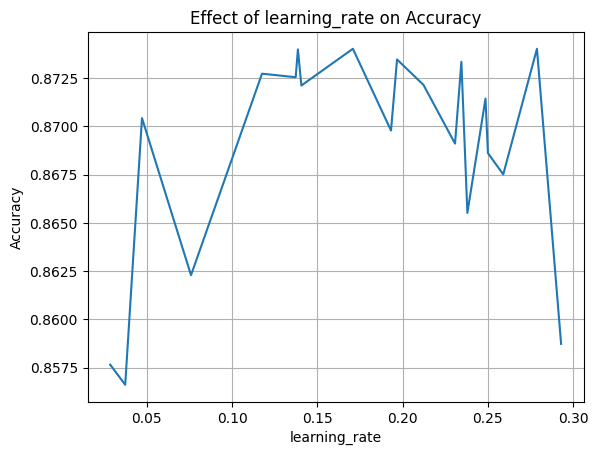

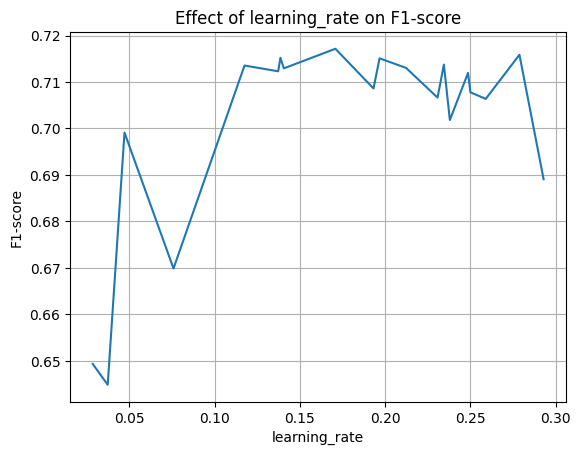

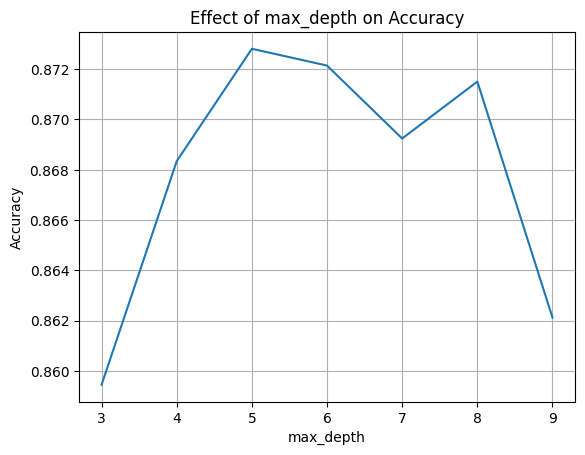

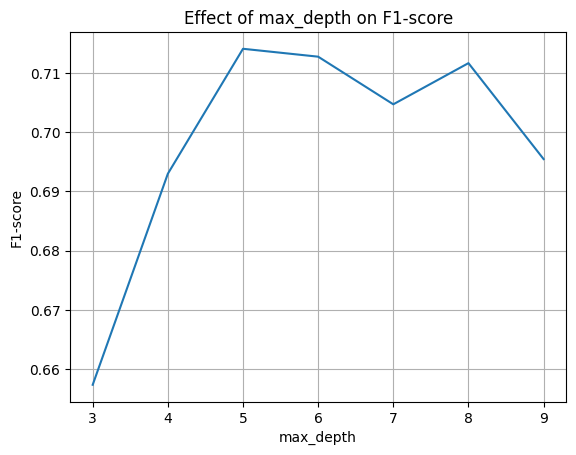

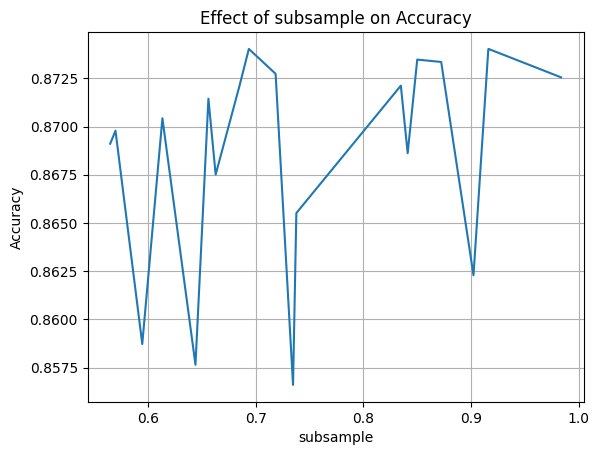

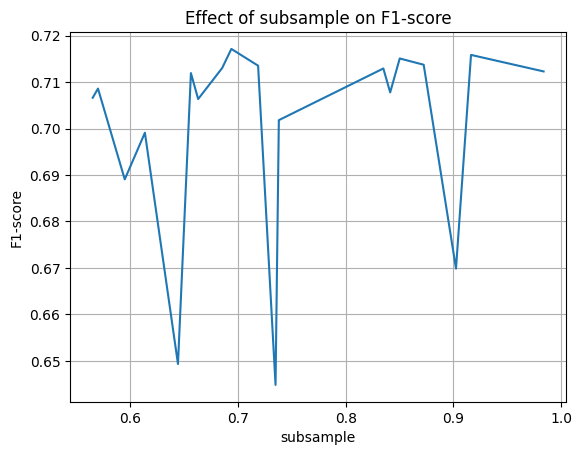

Best XGBoost Hyperparameter Configuration:
learning_rate = 0.1708
max_depth = 6
subsample = 0.6937
Accuracy = 0.8740
F1-score = 0.7171


In [6]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, ParameterGrid
from sklearn.metrics import accuracy_score, f1_score

# Stratified CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# num random tests
n_random_configs = 20
rng = np.random.default_rng(42) # seed

learning_rates = rng.uniform(0.01, 0.3, n_random_configs)
max_depths = rng.integers(3, 10, n_random_configs)
subsamples = rng.uniform(0.5, 1.0, n_random_configs)

results = []

for lr, md, ss in zip(learning_rates, max_depths, subsamples):
    acc_scores = []
    f1_scores = []

    for train_idx, test_idx in skf.split(X_encoded, y):
        X_train, X_test = X_encoded.iloc[train_idx], X_encoded.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = XGBClassifier(
            n_estimators=100,
            learning_rate=lr,
            max_depth=md,
            subsample=ss,
            eval_metric="logloss",
            random_state=42
        )

        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        acc_scores.append(accuracy_score(y_test, preds))
        f1_scores.append(f1_score(y_test, preds))

    results.append({
        "learning_rate": lr,
        "max_depth": md,
        "subsample": ss,
        "Accuracy": np.mean(acc_scores),
        "F1": np.mean(f1_scores)
    })

results_df = pd.DataFrame(results)
results_df.sort_values("F1", ascending=False).head()

# Sensitivity plots
params_to_plot = ["learning_rate", "max_depth", "subsample"]

for param in params_to_plot:
    grouped = results_df.groupby(param).mean(numeric_only=True)

    # Accuracy plot
    plt.figure()
    plt.plot(grouped.index, grouped["Accuracy"])
    plt.xlabel(param)
    plt.ylabel("Accuracy")
    plt.title(f"Effect of {param} on Accuracy")
    plt.grid(True)
    plt.show()

    # F1-score plot
    plt.figure()
    plt.plot(grouped.index, grouped["F1"])
    plt.xlabel(param)
    plt.ylabel("F1-score")
    plt.title(f"Effect of {param} on F1-score")
    plt.grid(True)
    plt.show()

best_config = results_df.sort_values(
    by=["F1", "Accuracy"], ascending=False
).iloc[0]

print("Best XGBoost Hyperparameter Configuration:")
print(f"learning_rate = {best_config['learning_rate']:.4f}")
print(f"max_depth = {int(best_config['max_depth'])}")
print(f"subsample = {best_config['subsample']:.4f}")
print(f"Accuracy = {best_config['Accuracy']:.4f}")
print(f"F1-score = {best_config['F1']:.4f}")



## Discussion

https://www.geeksforgeeks.org/machine-learning/xgboost/

This was a very interesting experiment that provided valuable information about the XGBoost model algorithm's strengths and limitations within the fairly difficult Adult dataset context. XGBoost is a powerful boosting-based ML algorithm for ensemble learning.

For this simulation, we train many XGBoost models using a random search over learning rate, subsampling ratio, and max depth. We run a cross validation training exercise for each parameter setup, aggregating the results (accuracy and f1) across folds for plotting later.

Starting with learning rate, it appears the optimal learning rate sits within the range of 0.1 to 0.25. Next, the optimal max depth is between 5 and 8. Finally, subsampling was much more volatile and doesn't seem to have a strong correspondence to accuracy or f1.

Overall, the sensitivity analysis aligns well with theoretical expectations of XGBoost. Learning rate and tree depth directly control the bias/variance trade-off, with moderate values yielding the strongest generalization. Subsampling acts as a variance-reduction mechanism, introducing stochasticity rather than consistently improving accuracy. Compared to single decision trees and bagging-based ensembles, XGBoost demonstrates superior robustness on the Adult dataset. This is because it sequentially focuses on difficult samples while using regularization to prevent overfitting.